# NB03: Sequence Clustering Analysis

MMseqs2 clustered the 815,571 unique PaperBLAST protein sequences at three identity thresholds:
- **90%** — strain-level redundancy (near-identical proteins)
- **50%** — protein family level
- **30%** — superfamily / fold level

This notebook analyzes cluster properties: size distributions, what the largest clusters are,
how clustering relates to literature coverage, and what fraction of sequence diversity
is captured at each level.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA = Path('../data')
FIG_OUT = Path('../figures')

# Load cluster membership TSVs (rep_id \t member_id)
clu90 = pd.read_csv(DATA / 'clusters_90pct.tsv', sep='\t', header=None, names=['rep', 'member'])
clu50 = pd.read_csv(DATA / 'clusters_50pct.tsv', sep='\t', header=None, names=['rep', 'member'])
clu30 = pd.read_csv(DATA / 'clusters_30pct.tsv', sep='\t', header=None, names=['rep', 'member'])

clusters = {'90%': clu90, '50%': clu50, '30%': clu30}

for label, df in clusters.items():
    n_clusters = df['rep'].nunique()
    n_seqs = df['member'].nunique()
    print(f'{label} identity: {n_clusters:,} clusters from {n_seqs:,} sequences')

90% identity: 628,441 clusters from 815,571 sequences
50% identity: 344,981 clusters from 815,571 sequences


30% identity: 214,534 clusters from 815,571 sequences


## 1. Cluster Size Distributions

In [2]:
# Compute cluster sizes
sizes = {}
for label, df in clusters.items():
    s = df.groupby('rep').size().reset_index(name='size')
    sizes[label] = s
    print(f'\n{label} identity cluster sizes:')
    print(s['size'].describe().to_string())
    print(f'  Singletons: {(s["size"] == 1).sum():,} ({100*(s["size"]==1).sum()/len(s):.1f}%)')
    print(f'  Size ≥ 10:  {(s["size"] >= 10).sum():,}')
    print(f'  Size ≥ 100: {(s["size"] >= 100).sum():,}')
    print(f'  Largest:    {s["size"].max():,}')


90% identity cluster sizes:
count    628441.000000
mean          1.297769
std           1.137450
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         212.000000
  Singletons: 523,368 (83.3%)
  Size ≥ 10:  1,275
  Size ≥ 100: 5
  Largest:    212

50% identity cluster sizes:
count    344981.000000
mean          2.364104
std           6.122783
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         650.000000
  Singletons: 232,732 (67.5%)
  Size ≥ 10:  11,252
  Size ≥ 100: 188
  Largest:    650



30% identity cluster sizes:
count    214534.000000
mean          3.801593
std          14.775991
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1616.000000
  Singletons: 134,720 (62.8%)
  Size ≥ 10:  14,105
  Size ≥ 100: 687
  Largest:    1,616


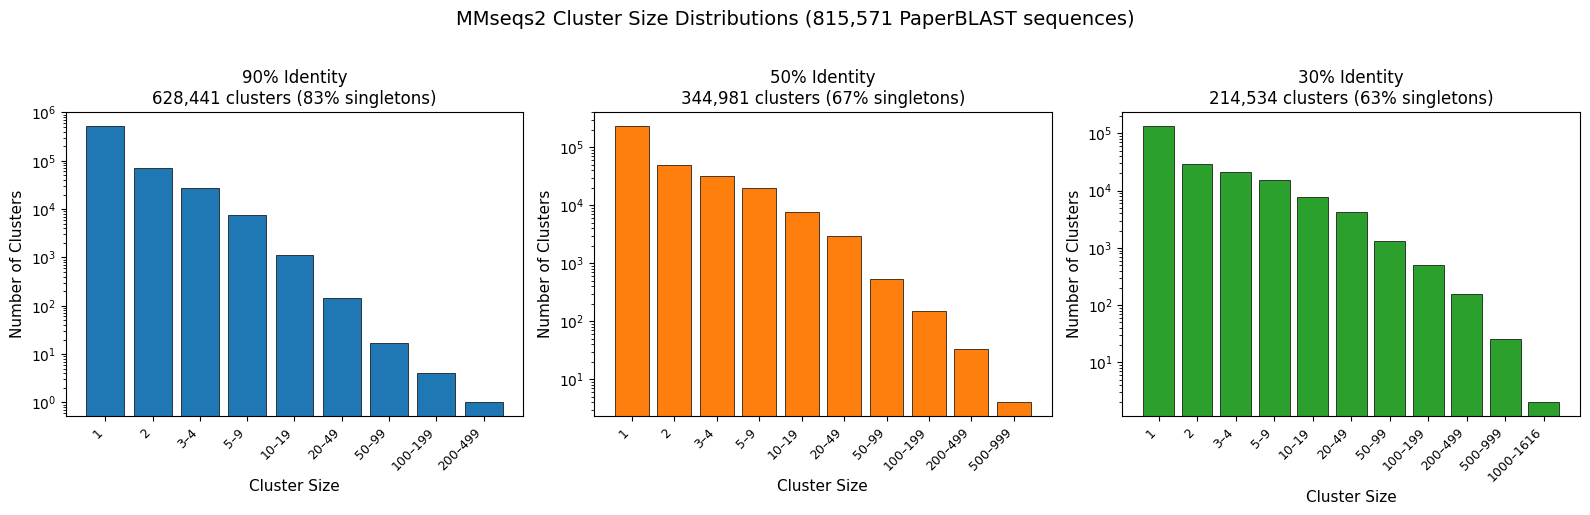

In [3]:
# Figure: Cluster size distributions — histograms
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = {'90%': '#1f77b4', '50%': '#ff7f0e', '30%': '#2ca02c'}

for ax, (label, s) in zip(axes, sizes.items()):
    # Bin singletons separately, then log-scale bins for the rest
    max_size = s['size'].max()
    bins = [1, 2, 3, 5, 10, 20, 50, 100, 200, 500, 1000, max_size + 1]
    counts = []
    labels_b = []
    for i in range(len(bins) - 1):
        c = ((s['size'] >= bins[i]) & (s['size'] < bins[i+1])).sum()
        if c > 0:
            counts.append(c)
            if bins[i+1] - bins[i] == 1:
                labels_b.append(f'{bins[i]}')
            else:
                labels_b.append(f'{bins[i]}–{bins[i+1]-1}')
    
    ax.bar(range(len(counts)), counts, color=colors[label], edgecolor='black', linewidth=0.5)
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(labels_b, rotation=45, ha='right', fontsize=9)
    ax.set_yscale('log')
    ax.set_xlabel('Cluster Size', fontsize=11)
    ax.set_ylabel('Number of Clusters', fontsize=11)
    n_clu = len(s)
    n_sing = (s['size'] == 1).sum()
    ax.set_title(f'{label} Identity\n{n_clu:,} clusters ({100*n_sing/n_clu:.0f}% singletons)', fontsize=12)

plt.suptitle('MMseqs2 Cluster Size Distributions (815,571 PaperBLAST sequences)', fontsize=14, y=1.02)
plt.tight_layout()
fig.savefig(FIG_OUT / 'cluster_size_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

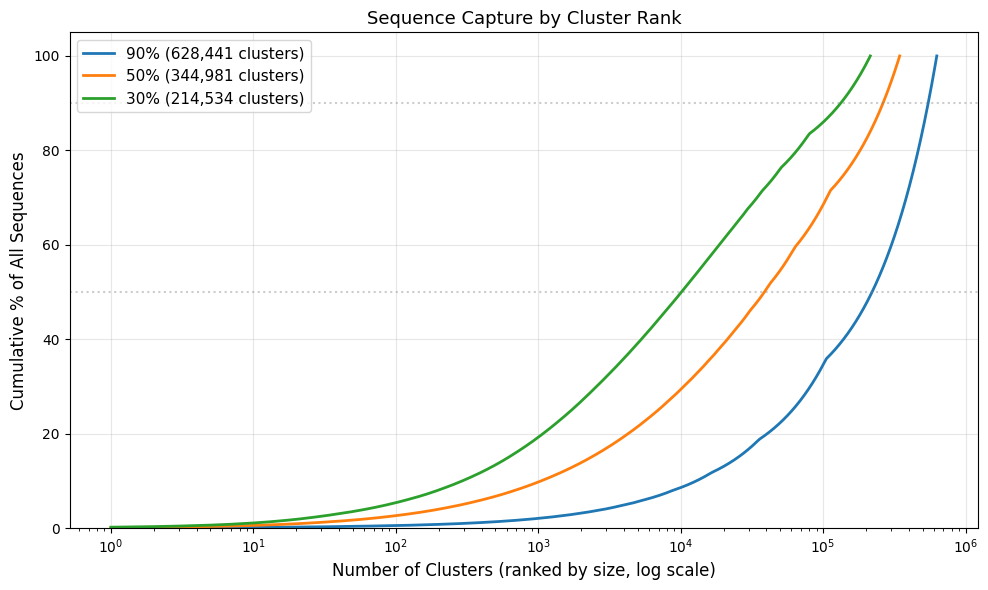

In [4]:
# Figure: Cumulative sequence capture — what fraction of sequences are in the top N clusters?
fig, ax = plt.subplots(figsize=(10, 6))

for label, s in sizes.items():
    s_sorted = s.sort_values('size', ascending=False).reset_index(drop=True)
    s_sorted['cum_seqs'] = s_sorted['size'].cumsum()
    total = s_sorted['size'].sum()
    s_sorted['cum_pct'] = 100 * s_sorted['cum_seqs'] / total
    s_sorted['rank'] = range(1, len(s_sorted) + 1)
    ax.plot(s_sorted['rank'], s_sorted['cum_pct'], 
            color=colors[label], linewidth=2, label=f'{label} ({len(s_sorted):,} clusters)')

ax.set_xscale('log')
ax.set_xlabel('Number of Clusters (ranked by size, log scale)', fontsize=12)
ax.set_ylabel('Cumulative % of All Sequences', fontsize=12)
ax.set_title('Sequence Capture by Cluster Rank', fontsize=13)
ax.axhline(50, color='gray', linestyle=':', alpha=0.4)
ax.axhline(90, color='gray', linestyle=':', alpha=0.4)
ax.legend(fontsize=11)
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_OUT / 'cluster_cumulative_capture.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. What Are the Largest Clusters?

In [5]:
from berdl_notebook_utils.setup_spark_session import get_spark_session
spark = get_spark_session()
DB = 'kescience_paperblast'

In [6]:
# Top 20 largest clusters at each threshold — identify the representative sequence
for label, s in sizes.items():
    top20 = s.nlargest(20, 'size')
    top_ids = top20['rep'].tolist()
    id_str = "','".join(top_ids)
    
    # Look up gene descriptions
    # First try the gene table
    desc_df = spark.sql(f"""
        SELECT geneId as rep, organism, desc
        FROM {DB}.gene
        WHERE geneId IN ('{id_str}')
    """).toPandas()
    
    # Also check curatedgene (some IDs may be there instead)
    curated_desc = spark.sql(f"""
        SELECT protId as rep, organism, desc
        FROM {DB}.curatedgene
        WHERE protId IN ('{id_str}')
    """).toPandas()
    
    all_desc = pd.concat([desc_df, curated_desc]).drop_duplicates(subset='rep')
    top20_annotated = top20.merge(all_desc, on='rep', how='left')
    
    print(f'\nTop 20 largest clusters at {label} identity:')
    print('=' * 120)
    for i, row in top20_annotated.iterrows():
        desc = str(row.get('desc', 'N/A'))[:60]
        org = str(row.get('organism', 'N/A'))[:30]
        print(f'  {row["size"]:>5} members | {row["rep"]:<20s} | {org:<30s} | {desc}')


Top 20 largest clusters at 90% identity:
    212 members | Q964E2               | Biomphalaria pfeifferi         | Actin, cytoplasmic
    148 members | O47047               | Eriogonum flavum               | Ribulose bisphosphate carboxylase large chain (Fragment)
    124 members | NP_001074329.2       | Gallus gallus                  | tubulin beta-3 chain
    110 members | VIMSS3629695         | Acinetobacter baumannii ATCC 1 | beta-lactamase
    103 members | REBASE::M.Sen9884I   | nan                            | nan
     99 members | P53504               | Sorghum bicolor                | Actin-1
     97 members | biolip::7yhnA        | nan                            | nan
     91 members | B9T228               | Ricinus communis               | Heat shock protein, putative
     90 members | P02269               | Asterias rubens                | Histone H2A
     85 members | A1L0U3               | Mus musculus                   | Histone H3 (Fragment)
     81 members | REBASE::M


Top 20 largest clusters at 50% identity:
    650 members | Q75HQ0               | Oryza sativa subsp. japonica   | Heat shock 70 kDa protein BIP4
    609 members | D4QFJ2               | Helicobasidium mompa           | Glyceraldehyde-3-phosphate dehydrogenase
    552 members | WP_064496902.1       | Methanocaldococcus jannaschii  | phosphopyruvate hydratase
    518 members | biolip::5dtfH        | nan                            | nan
    443 members | VIMSS5608095         | Porphyromonas gingivalis ATCC  | chaperonin GroEL
    425 members | G5B9Y3               | Heterocephalus glaber          | Stress-70 protein, mitochondrial
    394 members | P01978               | Tachyglossus aculeatus aculeat | Hemoglobin subunit alpha-2
    367 members | P48080               | Cyanophora paradoxa            | ATP synthase subunit alpha, cyanelle
    360 members | XP_014030161.1       | Salmo salar                    | tubulin beta-4B chain
    328 members | WP_000066485.1       | Escherichia c


Top 20 largest clusters at 30% identity:
   1616 members | H1ZV37               | Castellaniella defragrans (str | Geranial dehydrogenase
   1007 members | NP_001000974.1       | Rattus norvegicus              | olfactory receptor Olr820
    927 members | REBASE::M.Psp72II    | nan                            | nan
    859 members | XP_003529672.2       | Glycine max                    | cytochrome P450 71D8-like
    785 members | VIMSS846336          | Dehalococcoides ethenogenes 19 | 3-oxoacyl-acyl carrier protein reductase
    764 members | biolip::4cuoA        | nan                            | nan
    759 members | biolip::9gcjA        | nan                            | nan
    742 members | VIMSS53647           | Vibrio cholerae O1 biovar elto | fatty oxidation complex, beta subunit
    731 members | XP_012193596.1       | Saprolegnia parasitica CBS 223 | glyceraldehyde-3-phosphate dehydrogenase
    694 members | WP_023973651.1       | Clostridium beijerinckii NRRL  | methionine 

## 3. Clustering vs Literature Coverage

In [7]:
# For each cluster at 50% identity, count total papers across all members
# Use the papers_per_gene data from NB02
ppg = pd.read_csv(DATA / 'papers_per_gene.csv')

# Map cluster membership to paper counts
clu50_with_papers = clu50.merge(ppg, left_on='member', right_on='geneId', how='left')
clu50_with_papers['n_papers'] = clu50_with_papers['n_papers'].fillna(0).astype(int)

# Aggregate by cluster
cluster_lit = clu50_with_papers.groupby('rep').agg(
    cluster_size=('member', 'count'),
    total_papers=('n_papers', 'sum'),
    max_papers=('n_papers', 'max'),
    members_with_papers=('n_papers', lambda x: (x > 0).sum())
).reset_index()

cluster_lit['papers_per_member'] = cluster_lit['total_papers'] / cluster_lit['cluster_size']
cluster_lit['pct_with_papers'] = 100 * cluster_lit['members_with_papers'] / cluster_lit['cluster_size']

print('Cluster-level literature coverage (50% identity):')
print(f'  Clusters with 0 papers across ALL members: {(cluster_lit["total_papers"] == 0).sum():,} '
      f'({100*(cluster_lit["total_papers"]==0).sum()/len(cluster_lit):.1f}%)')
print(f'  Clusters with ≥1 paper: {(cluster_lit["total_papers"] > 0).sum():,}')
print(f'  Clusters with ≥10 papers: {(cluster_lit["total_papers"] >= 10).sum():,}')
print(f'  Clusters with ≥100 papers: {(cluster_lit["total_papers"] >= 100).sum():,}')
print()

# For multi-member clusters, how many have at least one studied member?
multi = cluster_lit[cluster_lit['cluster_size'] > 1]
print(f'Multi-member clusters (size > 1): {len(multi):,}')
print(f'  With ≥1 studied member: {(multi["members_with_papers"] > 0).sum():,} '
      f'({100*(multi["members_with_papers"]>0).sum()/len(multi):.1f}%)')
print(f'  With NO studied members: {(multi["members_with_papers"] == 0).sum():,}')

Cluster-level literature coverage (50% identity):
  Clusters with 0 papers across ALL members: 31,653 (9.2%)
  Clusters with ≥1 paper: 313,328
  Clusters with ≥10 papers: 33,318
  Clusters with ≥100 papers: 2,638

Multi-member clusters (size > 1): 112,249
  With ≥1 studied member: 107,031 (95.4%)
  With NO studied members: 5,218


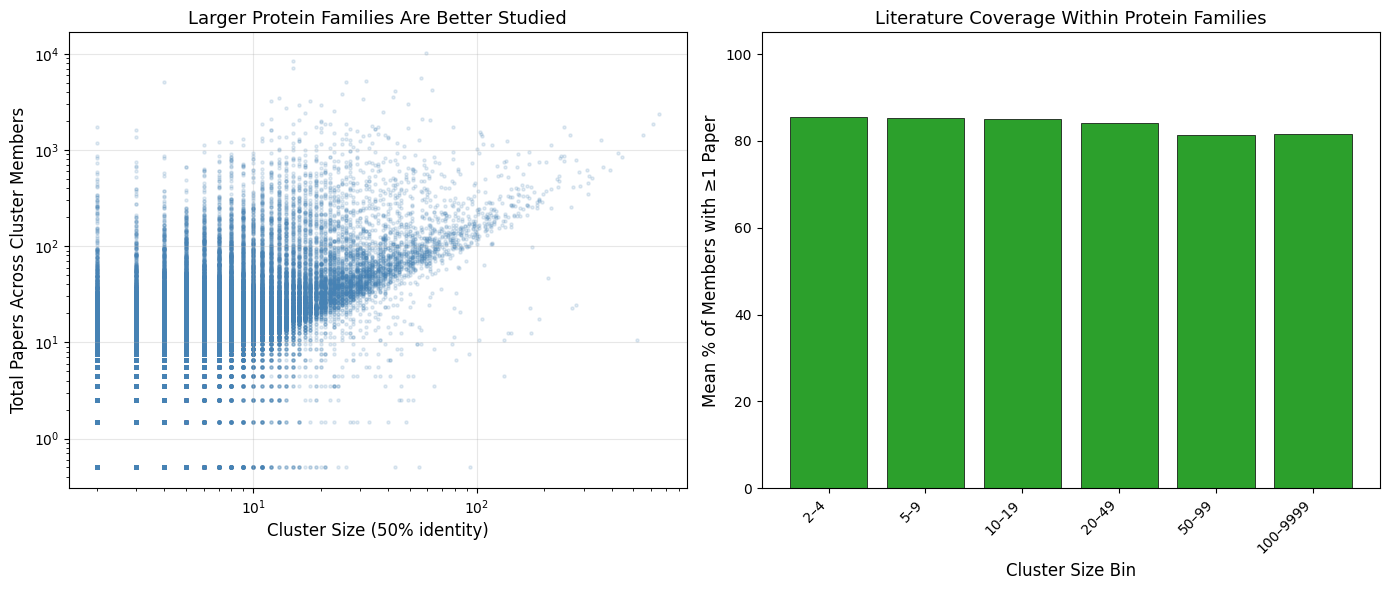

In [8]:
# Figure: Cluster size vs literature coverage
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Scatter — cluster size vs total papers (50% identity)
ax = axes[0]
sub = cluster_lit[cluster_lit['cluster_size'] > 1].copy()
ax.scatter(sub['cluster_size'], sub['total_papers'] + 0.5, 
           alpha=0.15, s=5, color='steelblue', rasterized=True)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Cluster Size (50% identity)', fontsize=12)
ax.set_ylabel('Total Papers Across Cluster Members', fontsize=12)
ax.set_title('Larger Protein Families Are Better Studied', fontsize=13)
ax.grid(True, alpha=0.3)

# Panel B: What fraction of cluster members have papers?
ax = axes[1]
# Bin by cluster size
size_bins = [2, 5, 10, 20, 50, 100, 10000]
bin_labels = []
mean_pcts = []
for i in range(len(size_bins) - 1):
    mask = (sub['cluster_size'] >= size_bins[i]) & (sub['cluster_size'] < size_bins[i+1])
    if mask.sum() > 0:
        mean_pct = sub.loc[mask, 'pct_with_papers'].mean()
        mean_pcts.append(mean_pct)
        bin_labels.append(f'{size_bins[i]}–{size_bins[i+1]-1}')

ax.bar(range(len(mean_pcts)), mean_pcts, color='#2ca02c', edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(mean_pcts)))
ax.set_xticklabels(bin_labels, rotation=45, ha='right')
ax.set_xlabel('Cluster Size Bin', fontsize=12)
ax.set_ylabel('Mean % of Members with ≥1 Paper', fontsize=12)
ax.set_title('Literature Coverage Within Protein Families', fontsize=13)
ax.set_ylim(0, 105)

plt.tight_layout()
fig.savefig(FIG_OUT / 'cluster_vs_literature.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Redundancy Cascade — How Much Is Truly Unique?

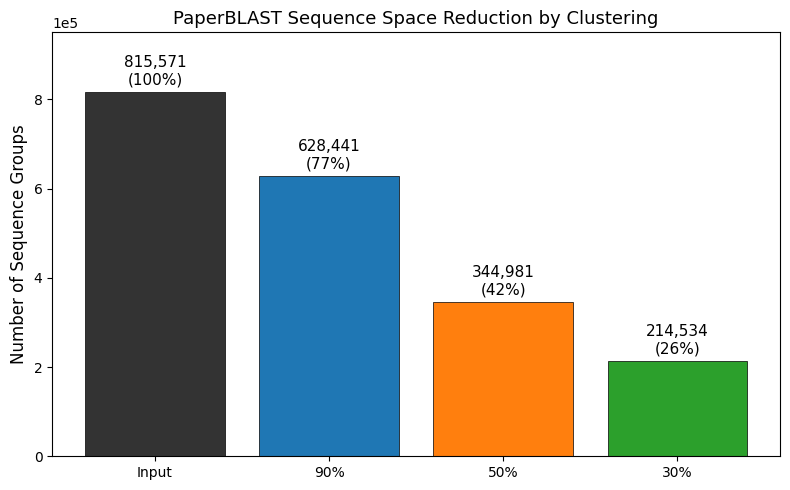

Sequence space summary:
       Input:  815,571 groups (100.0%)
         90%:  628,441 groups (77.1%)
         50%:  344,981 groups (42.3%)
         30%:  214,534 groups (26.3%)


In [9]:
# Summary figure: sequence space reduction at each threshold
thresholds = ['Input', '90%', '50%', '30%']
n_clusters = [
    815571,
    sizes['90%']['rep'].nunique(),
    sizes['50%']['rep'].nunique(),
    sizes['30%']['rep'].nunique()
]

fig, ax = plt.subplots(figsize=(8, 5))
bar_colors = ['#333333', '#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax.bar(thresholds, n_clusters, color=bar_colors, edgecolor='black', linewidth=0.5)

# Label bars
for bar, n in zip(bars, n_clusters):
    pct = 100 * n / 815571
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10000,
            f'{n:,}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=11)

ax.set_ylabel('Number of Sequence Groups', fontsize=12)
ax.set_title('PaperBLAST Sequence Space Reduction by Clustering', fontsize=13)
ax.set_ylim(0, 950000)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.tight_layout()
fig.savefig(FIG_OUT / 'sequence_space_reduction.png', dpi=150, bbox_inches='tight')
plt.show()

print('Sequence space summary:')
for t, n in zip(thresholds, n_clusters):
    print(f'  {t:>10}: {n:>8,} groups ({100*n/815571:.1f}%)')

## 5. Dark Protein Families — Clusters With No Literature

In [10]:
# At 50% identity, which multi-member clusters have ZERO literature?
dark_families = cluster_lit[(cluster_lit['total_papers'] == 0) & (cluster_lit['cluster_size'] > 1)]
dark_families_sorted = dark_families.sort_values('cluster_size', ascending=False)

print(f'"Dark" protein families (50% identity, size>1, 0 papers): {len(dark_families):,}')
print(f'Total sequences in dark families: {dark_families["cluster_size"].sum():,}')
print()

# Top 20 largest dark families
top_dark = dark_families_sorted.head(20)
dark_ids = top_dark['rep'].tolist()
id_str = "','".join(dark_ids)

dark_desc = spark.sql(f"""
    SELECT geneId as rep, organism, desc
    FROM {DB}.gene
    WHERE geneId IN ('{id_str}')
""").toPandas()

curated_dark = spark.sql(f"""
    SELECT protId as rep, organism, desc
    FROM {DB}.curatedgene
    WHERE protId IN ('{id_str}')
""").toPandas()

all_dark_desc = pd.concat([dark_desc, curated_dark]).drop_duplicates(subset='rep')
top_dark_ann = top_dark.merge(all_dark_desc, on='rep', how='left')

print('Top 20 largest dark protein families:')
for _, row in top_dark_ann.iterrows():
    desc = str(row.get('desc', 'N/A'))[:60]
    org = str(row.get('organism', 'N/A'))[:30]
    print(f'  {row["cluster_size"]:>4} members | {row["rep"]:<20s} | {org:<30s} | {desc}')

"Dark" protein families (50% identity, size>1, 0 papers): 5,218
Total sequences in dark families: 14,534



Top 20 largest dark protein families:
    93 members | biolip::2em9A        | nan                            | nan
    55 members | REBASE::M.PalEH1III  | nan                            | nan
    43 members | biolip::4gg8E        | nan                            | nan
    26 members | biolip::6d67A        | nan                            | nan
    24 members | REBASE::M.Tku12350II | nan                            | nan
    21 members | BRENDA::A5J0Z9       | nan                            | nan
    21 members | biolip::8uzdA        | nan                            | nan
    21 members | REBASE::M1.Hfe13102I | nan                            | nan
    20 members | REBASE::M.Cau10061I  | nan                            | nan
    19 members | REBASE::M.Kaq16071II | nan                            | nan
    19 members | BRENDA::T1KF23       | nan                            | nan
    18 members | biolip::6dd5A        | nan                            | nan
    18 members | REBASE::M.Aol110486I 

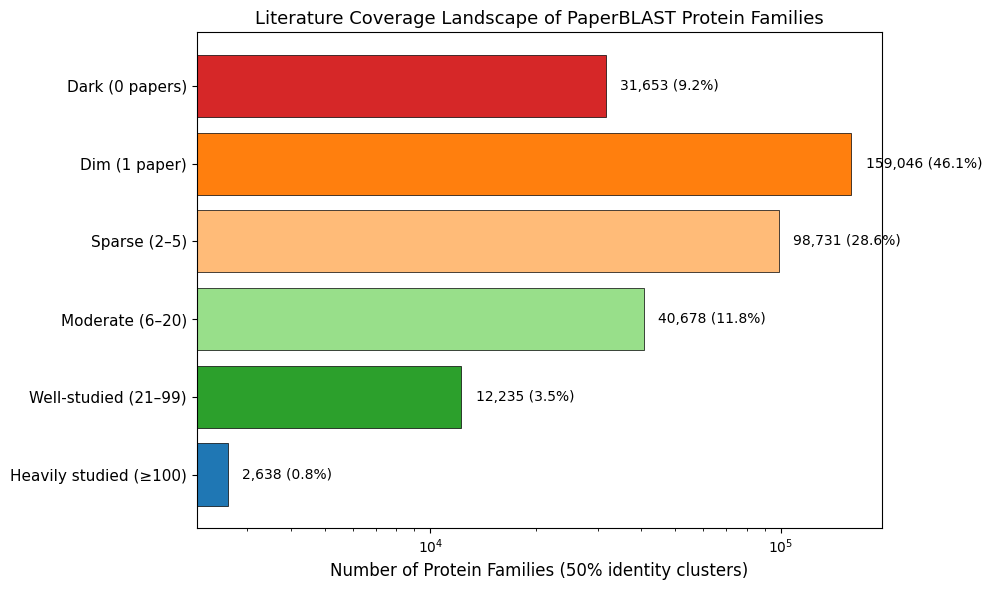


Literature coverage landscape (50% identity families):
  Dark (0 papers)               :   31,653 (9.2%)
  Dim (1 paper)                 :  159,046 (46.1%)
  Sparse (2–5)                  :   98,731 (28.6%)
  Moderate (6–20)               :   40,678 (11.8%)
  Well-studied (21–99)          :   12,235 (3.5%)
  Heavily studied (≥100)        :    2,638 (0.8%)


In [11]:
# Figure: Literature coverage landscape at 50% identity
fig, ax = plt.subplots(figsize=(10, 6))

# Classify clusters
categories = {
    'Dark (0 papers)': (cluster_lit['total_papers'] == 0).sum(),
    'Dim (1 paper)': (cluster_lit['total_papers'] == 1).sum(),
    'Sparse (2–5)': ((cluster_lit['total_papers'] >= 2) & (cluster_lit['total_papers'] <= 5)).sum(),
    'Moderate (6–20)': ((cluster_lit['total_papers'] >= 6) & (cluster_lit['total_papers'] <= 20)).sum(),
    'Well-studied (21–99)': ((cluster_lit['total_papers'] >= 21) & (cluster_lit['total_papers'] <= 99)).sum(),
    'Heavily studied (≥100)': (cluster_lit['total_papers'] >= 100).sum(),
}

cats = list(categories.keys())
vals = list(categories.values())
cat_colors = ['#d62728', '#ff7f0e', '#ffbb78', '#98df8a', '#2ca02c', '#1f77b4']

bars = ax.barh(range(len(cats)), vals, color=cat_colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(cats)))
ax.set_yticklabels(cats, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Number of Protein Families (50% identity clusters)', fontsize=12)
ax.set_title('Literature Coverage Landscape of PaperBLAST Protein Families', fontsize=13)
ax.set_xscale('log')

for bar, val in zip(bars, vals):
    pct = 100 * val / len(cluster_lit)
    ax.text(val * 1.1, bar.get_y() + bar.get_height()/2,
            f'{val:,} ({pct:.1f}%)', va='center', fontsize=10)

plt.tight_layout()
fig.savefig(FIG_OUT / 'literature_coverage_landscape.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nLiterature coverage landscape (50% identity families):')
for cat, val in categories.items():
    print(f'  {cat:30s}: {val:>8,} ({100*val/len(cluster_lit):.1f}%)')

## 6. Summary

In [12]:
print('=' * 60)
print('SEQUENCE CLUSTERING SUMMARY')
print('=' * 60)
print(f'Input sequences:       {815571:>10,}')
print(f'90% identity clusters: {n_clusters[1]:>10,} ({100*n_clusters[1]/815571:.1f}%)')
print(f'50% identity clusters: {n_clusters[2]:>10,} ({100*n_clusters[2]/815571:.1f}%)')
print(f'30% identity clusters: {n_clusters[3]:>10,} ({100*n_clusters[3]/815571:.1f}%)')
print()
print('At 50% identity (protein family level):')
dark_n = (cluster_lit['total_papers'] == 0).sum()
total_fam = len(cluster_lit)
print(f'  Families with 0 papers:    {dark_n:>8,} ({100*dark_n/total_fam:.1f}%)')
print(f'  Families with ≥1 paper:    {total_fam - dark_n:>8,} ({100*(total_fam-dark_n)/total_fam:.1f}%)')
heavy = (cluster_lit['total_papers'] >= 100).sum()
print(f'  Families with ≥100 papers: {heavy:>8,} ({100*heavy/total_fam:.1f}%)')

# Save cluster sizes
for label, s in sizes.items():
    pct_label = label.replace('%', 'pct')
    s.to_csv(DATA / f'cluster_sizes_{pct_label}.csv', index=False)

cluster_lit.to_csv(DATA / 'cluster_literature_50pct.csv', index=False)
print('\nSaved cluster analysis to data/')

SEQUENCE CLUSTERING SUMMARY
Input sequences:          815,571
90% identity clusters:    628,441 (77.1%)
50% identity clusters:    344,981 (42.3%)
30% identity clusters:    214,534 (26.3%)

At 50% identity (protein family level):
  Families with 0 papers:      31,653 (9.2%)
  Families with ≥1 paper:     313,328 (90.8%)
  Families with ≥100 papers:    2,638 (0.8%)



Saved cluster analysis to data/
